# Dreambooth fine-tuning for Stable Diffusion

In this notebook, we'll try to use [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth) to generate images of military vehicles for training our vehicle detection model. Our model suffers from a lack of diversity in its training data available, so we'll see if we can improve our training dataset with synthetic images generated by a text-to-image model. [Dreambooth](https://arxiv.org/abs/2208.12242) is a method to personnalize text-to-image models with just a few images of a subject.

We use the training script provided by diffusers [here](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth) and follow the guide available [here](https://huggingface.co/docs/diffusers/training/dreambooth).

## Configuration
As explained in the guide, dreambooth is quite susceptible to overfitting and finding the right hyperparameters can be challenging. We tried various configurations to find the one that works best for our use case. We also followed the advice from [their analysis](https://huggingface.co/blog/dreambooth) on how to train dreambooth.

Overall, we found that using Low-Rank Adaptation of Large Language Models (LoRA) gives better results, or at least is easier to train and finetune. We also took advantage of GPU optimization tools, such as [xFormers](https://github.com/facebookresearch/xformers) (enabled by adding the `--enable_xformers_memory_efficient_attention` argument to the training script) and [bitsandbytes](https://github.com/TimDettmers/bitsandbytes) 8-bit optimizer (add `--use_8bit_adam`).

## Setup

Before running the script, we need to install the dependencies. Installing the dependencies with poetry caused some issues, so we recommend to use a python virtual env manager to install dependencies.

In [ ]:
# Clone the huggingface diffusers repo and install dependencies
!git clone https://github.com/huggingface/diffusers ../diffusers
!pip install -e ../diffusers
!pip install -U -r ../diffusers/examples/dreambooth/requirements.txt
!pip install bitsandbytes xformers matplotlib
!accelerate config default

## Fine-tune the model

To train the model, we found these settings work best: we train with LoRA, on 800 steps, saving checkpoints every 250 step. We finetune the text_encoder along with the unet. The following script will also train dreambooth with prior-preservation by generating 100 images of tank. However, the images generated with Stable Diffusion often have undesirable artifacts and it would probably be better to use our own class dataset.

#### Instance data

To train dreambooth, you need to provide a limited sample of a specific subject instance that dreambooth will learn. In this notebook, we'll try to use dreambooth to generate images of a specific type of tank, the [Leclerc Tank](https://en.wikipedia.org/wiki/Leclerc_tank). We created a dataset of 15 images of the Leclerc Tank to finetune dreambooth on by using our [GoogleImageScraper](./scraper/google.py). You can generate your own dataset or use the one we added to the [resources dir](../resources/leclerc).

#### Prior preservation

Prior preservation is used to avoid overfitting and language-drift (see the [dreambooth paper](https://arxiv.org/abs/2208.12242)). For prior preservation, we need other images of the same class (military vehicles). We have two options: we can use some of the tank images that we gathered from open-source image datasets (see the [TankDetectionYoloV8Train notebook](./TankDetectionYolov8Train.ipynb), or we can use Stable Diffusion to generate thoses images itself. Either case works fine, however the images generated with Stable Diffusion often have undesirable artifacts (multiple canons, etc.) which could probably be avoided by using a proper curated dataset.

To sample 200 tank images from our `military-vehicles` dataset, run the following script. Otherwise, if the `tanks` directory is empty, Stable Diffusion will generate the missing tank images.

In [ ]:
import fiftyone as fo

export_dir = "../tanks"

# The dataset or view to export
dataset = fo.load_dataset("military-vehicles").take(200)

# Export the dataset
dataset.export(export_dir=export_dir, dataset_type=fo.types.ImageDirectory)

To train the model, we found these settings work best: we train with LoRA, on 800 steps, saving checkpoints every 250 step. We finetune the text_encoder along with the unet. We use prior-preservation with 200 samples of tank images.

In [18]:
!accelerate launch ../diffusers/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --train_text_encoder \
  --instance_data_dir="../resources/leclerc" \
  --class_data_dir="../tanks" \
  --output_dir="../adomvi-dream-tank" \
  --with_prior_preservation \
  --prior_loss_weight=1.0 \
  --instance_prompt="a photo of [L] tank" \
  --class_prompt="a photo of a tank" \
  --num_class_images=200 \
  --resolution=512 \
  --train_batch_size=1 \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=250 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=800 \
  --validation_prompt="A photo of [L] tank on the moon" \
  --validation_epochs=50 \
  --seed="0"

07/26/2023 16:12:42 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
{'num_class_embeds', 'encoder_hid_dim', 'use_linear_projection', 'time_embedding_dim', 'time_cond_proj_dim', 'time_embedding_act_fn', 'upcast_attention', 'num_attention_heads', 'cross_attention_norm', 'only_cross_attention', 'mid_block_only_cross_attention', 'addition_embed_type', 'encoder_hid_dim_type', 'dual_cross_attention', 'conv_out_kernel', 'resnet_skip_time_act', 'conv_in_kernel', 'class_embeddings_concat', 'mid_block_type', 'projection_class_embeddings_input_dim', 'addition_time_embed_dim', 'time_embedding

## Running inference

#### Downloading our sample model weights

Finetuning a model with dreambooth requires a GPU with a lot of memory. If this is unavailable to you, you can download the model weights from on our training run [here](https://github.com/jonasrenault/adomvi/releases/download/v1.1.0/adomvi-dream-tank.tar.gz). Unzip the weights in a directory called `adomvi-dream-tank` at the root of the project.

#### Generating images from text prompts

Once our model is trained, we can run inference to generate new images of a leclerc tank. Since our original military vehicle dataset lacks images taken from a distance, or where the subject is partially hidden, we try to generate such images by constructing a complex prompt.

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


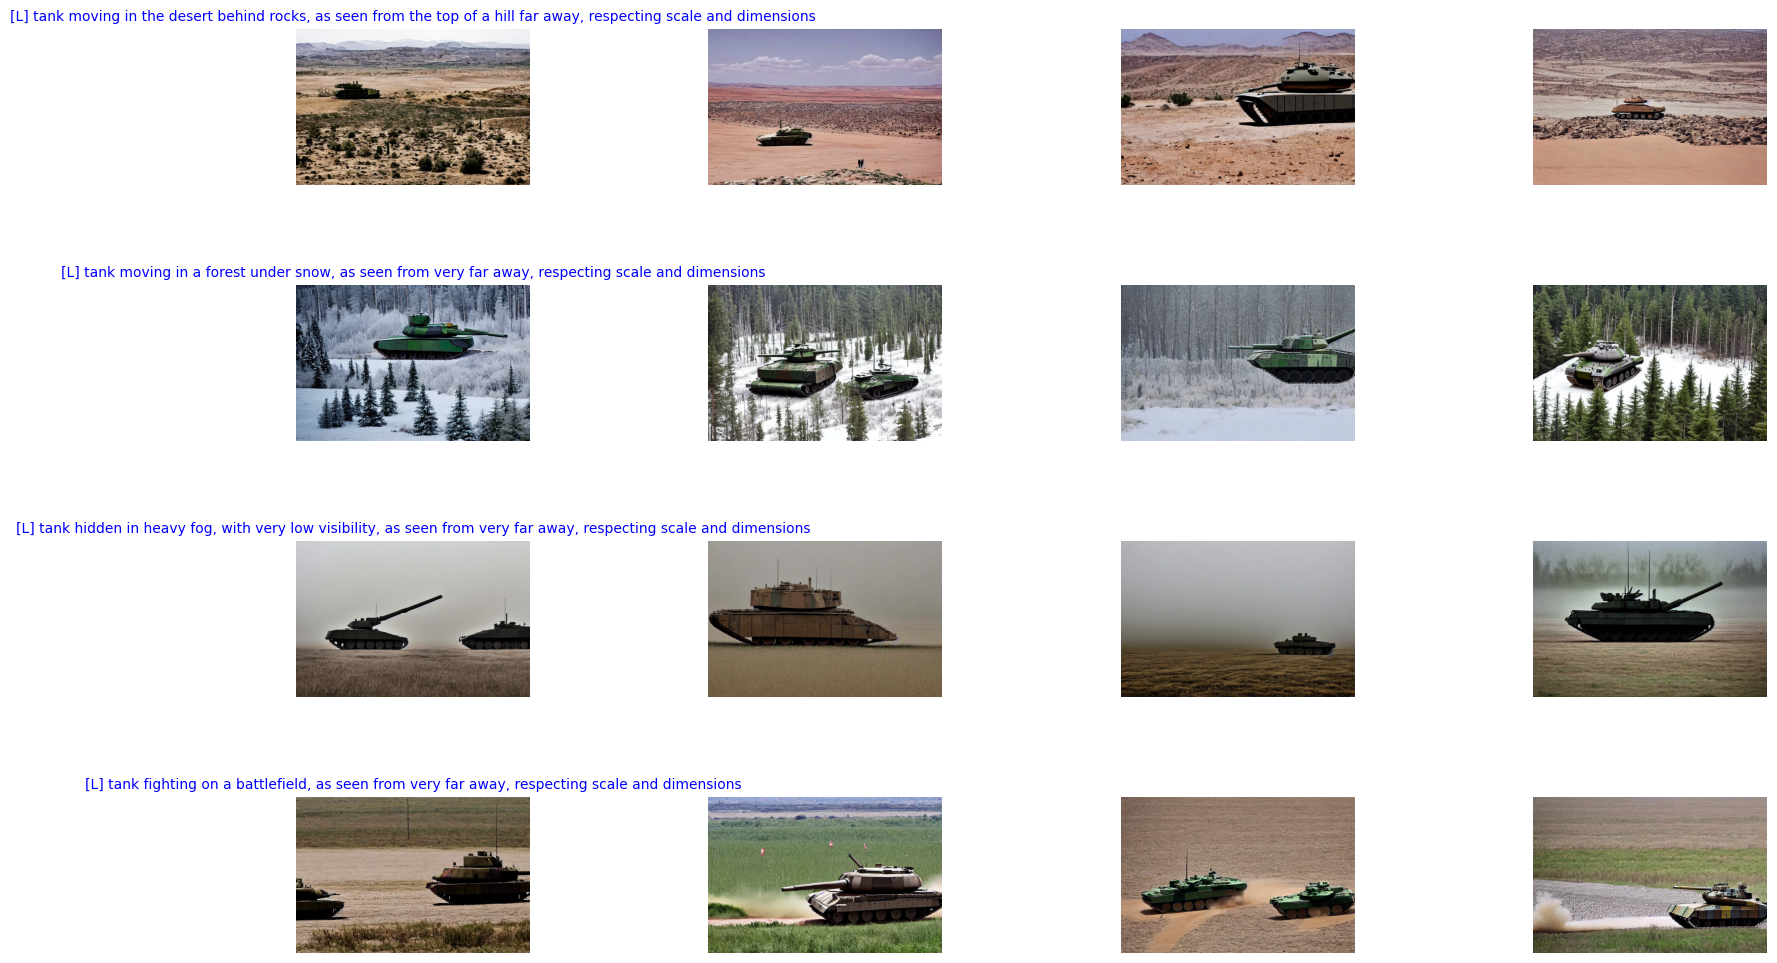

In [27]:
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# to load a checkpoint, change the lora_model_id path, i.e. lora_model_id = "adomvi-dream-tank/checkpoint-500"
lora_model_id = "../adomvi-dream-tank"
model_base = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16, safety_checker=None)
pipe = pipe.to("cuda")
pipe.load_lora_weights(lora_model_id)

prompts = {
    "desert": "[L] tank moving in the desert behind rocks, as seen from the top of a hill far away, respecting scale and dimensions",
    "snow": "[L] tank moving in a forest under snow, as seen from very far away, respecting scale and dimensions",
    "fog": "[L] tank hidden in heavy fog, with very low visibility, as seen from very far away, respecting scale and dimensions",
    "battle": "[L] tank fighting on a battlefield, as seen from very far away, respecting scale and dimensions",
}

negative_prompt = "close-up, upfront, unobstructed, bad scale, (inaccurate canons:1.2), extra canons"

n_samples_per_prompt = 4
fig = plt.figure(figsize=(20, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(len(prompts), n_samples_per_prompt), axes_pad=1, aspect=False)
ax_count = 0
for token, prompt in prompts.items():
    images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        width=768,
        height=512,
        num_inference_steps=100,
        num_images_per_prompt=n_samples_per_prompt,
        # generator=torch.manual_seed(0),
        guidance_scale=7.5,
        cross_attention_kwargs={"scale": 0.85},
    ).images

    grid[ax_count].set_title(prompt, fontsize = 10, color = 'blue')

    for i in range(n_samples_per_prompt):
        images[i].save(f"../inference/tank-{token}-{i}.png")
        grid[ax_count].imshow(images[i])
        grid[ax_count].axis("off")
        ax_count += 1

plt.show()